In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random 

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [71]:
data = pd.read_csv('data/cgm_to_meal_start.csv')
data = data.dropna()
cgm_diff = data['cgm'].diff()
data['diff'] = cgm_diff
data = data.dropna()
data = data.reset_index(drop=True)

In [72]:
# non_meal_diff = data.loc[(data['meal'] == 0) & (data['diff'] < 20) & (data['diff'] > -20)]['diff']
# meal_diff = data.loc[(data['meal'] == 1) & (data['diff'] < 20) & (data['diff'] > -20) ]['diff']
# plt.hist([meal_diff, non_meal_diff], bins = 50, label=['meal', 'non-meal'])
# plt.legend()

In [73]:
near_param = 10

meal_indices = data.index[data['meal_start'] == 1]
meal_data_X = []
for idx in meal_indices:
    near_idx_points = data.iloc[list(range(idx - 1, idx - near_param - 1, -1))]
    meal_data_X.append(near_idx_points['diff'].to_list())

non_meal_indices = data.index[data['meal_start'] == 0]
non_meal_data_X = []
for idx in non_meal_indices:
    near_idx_points = data.iloc[list(range(idx - 1, idx - near_param - 1, -1))]
    non_meal_data_X.append(near_idx_points['diff'].to_list())

In [74]:
meal_data_Y = np.ones(len(meal_data_X))
non_meal_data_Y = np.zeros(len(non_meal_data_X))
meal_data_X = np.array(meal_data_X)
non_meal_data_X = np.array(non_meal_data_X)

In [79]:
numPoints_non_meal = 4000

numPoints_meal = meal_data_X.shape[0]
sampled_indices_non_meal = np.array(random.sample(range(0,non_meal_data_X.shape[0]),numPoints_non_meal))
sampled_indices_meal = np.array(random.sample(range(0,meal_data_X.shape[0]),numPoints_meal))

trainDataX_non_meal = non_meal_data_X[sampled_indices_non_meal]
trainDataX_meal = meal_data_X[sampled_indices_meal]
trainDataY_non_meal = non_meal_data_Y[sampled_indices_non_meal]
trainDataY_meal = meal_data_Y[sampled_indices_meal]

Data_in = np.concatenate((trainDataX_meal,trainDataX_non_meal),axis=0)
Data_out = np.concatenate((trainDataY_meal,trainDataY_non_meal),axis=0)
print(Data_out)

[1. 1. 1. ... 0. 0. 0.]


Nearest Neighbors 0.8175
[[519 267]
 [ 25 789]]


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Linear SVM 0.515625
[[288 498]
 [277 537]]


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


RBF SVM 0.851875
[[635 151]
 [ 86 728]]


/opt/anaconda3/envs/MC-final-project/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


KeyboardInterrupt: 

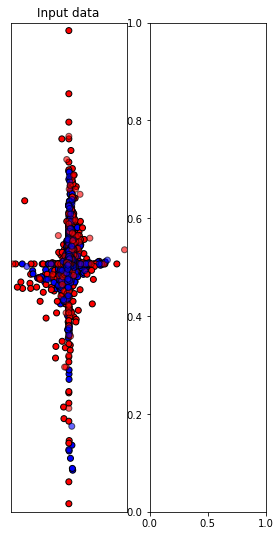

In [86]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# X, y = make_classification(n_features=10, n_redundant=0, n_informative=2,
#                            random_state=1, n_clusters_per_class=1)
# rng = np.random.RandomState(2)
# X += 2 * rng.uniform(size=X.shape)
# linearly_separable = (X, y)
# oversample = SMOTE()
# Data_in, Data_out = oversample.fit_resample(Data_in, Data_out)
Data = [Data_in,Data_out]
datasets = [Data]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.2, random_state=42)
    
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        reg = clf.fit(X_train, y_train)
        score = reg.score(X_test, y_test)
        print(name,score)
        pred = reg.predict(X_test)
        print(confusion_matrix(y_test, pred))
#         confusion_matrix(y_true, y_pred)
        

#         # Plot the decision boundary. For that, we will assign a color to each
#         # point in the mesh [x_min, x_max]x[y_min, y_max].
#         if hasattr(clf, "decision_function"):
#             Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#         else:
#             Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#         # Plot the training points
#         ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                    edgecolors='k')
#         # Plot the testing points
#         ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
#                    edgecolors='k', alpha=0.6)

#         ax.set_xlim(xx.min(), xx.max())
#         ax.set_ylim(yy.min(), yy.max())
#         ax.set_xticks(())
#         ax.set_yticks(())
#         if ds_cnt == 0:
#             ax.set_title(name)
#         ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#                 size=15, horizontalalignment='right')
#         i += 1

# plt.tight_layout()
# plt.show()